In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

Read the file of 2016 World Happiness Report. The dataset is extracted freely from: https://www.kaggle.com/unsdsn/world-happiness/download


In [2]:
df = pd.read_csv('2016.csv')
df.head()


,Country,Region,Happiness Rank,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Denmark,Western Europe,1,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,2.73939
1,Switzerland,Western Europe,2,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,2.69463
2,Iceland,Western Europe,3,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,2.83137
3,Norway,Western Europe,4,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,2.66465
4,Finland,Western Europe,5,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,2.82596


Check the information of the dataset two see if there are any missing values or parts that need cleaning.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 13 columns):
Country                          157 non-null object
Region                           157 non-null object
Happiness Rank                   157 non-null int64
Happiness Score                  157 non-null float64
Lower Confidence Interval        157 non-null float64
Upper Confidence Interval        157 non-null float64
Economy (GDP per Capita)         157 non-null float64
Family                           157 non-null float64
Health (Life Expectancy)         157 non-null float64
Freedom                          157 non-null float64
Trust (Government Corruption)    157 non-null float64
Generosity                       157 non-null float64
Dystopia Residual                157 non-null float64
dtypes: float64(10), int64(1), object(2)
memory usage: 16.0+ KB


This looks like an impeccable dataset. However, the 'Happiness Rank' column is completely correspondant to the 
'Happiness Score'. It is unnecessary for the dataset to contain this variable. (One note: The 'Dystopia Residual' variable sets up a benchmark to compare using an imaginary country where people are the least happy. The full explanation can be found in Kaggle's website).

In [4]:
df = df.drop(columns = ['Happiness Rank'])

The Region column contains categorical variables. Now transform into one-hot matrix.

In [5]:
df['Region'].value_counts()

Sub-Saharan Africa                 38
Central and Eastern Europe         29
Latin America and Caribbean        24
Western Europe                     21
Middle East and Northern Africa    19
Southeastern Asia                   9
Southern Asia                       7
Eastern Asia                        6
Australia and New Zealand           2
North America                       2
Name: Region, dtype: int64

In [6]:
one_hot = pd.get_dummies(df['Region'])
df = df.drop(columns = ['Region'])
df = df.join(one_hot)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 21 columns):
Country                            157 non-null object
Happiness Score                    157 non-null float64
Lower Confidence Interval          157 non-null float64
Upper Confidence Interval          157 non-null float64
Economy (GDP per Capita)           157 non-null float64
Family                             157 non-null float64
Health (Life Expectancy)           157 non-null float64
Freedom                            157 non-null float64
Trust (Government Corruption)      157 non-null float64
Generosity                         157 non-null float64
Dystopia Residual                  157 non-null float64
Australia and New Zealand          157 non-null uint8
Central and Eastern Europe         157 non-null uint8
Eastern Asia                       157 non-null uint8
Latin America and Caribbean        157 non-null uint8
Middle East and Northern Africa    157 non-null uint8
North Amer

I pick "Happiness Score" as my y variable to predict. Let's see how other variables correlates to my dependent variable, y.

In [7]:
#m = df.drop(columns = ['Country'])
#sns.pairplot(m, height = 1.2, aspect=1.5)
df.columns

Index(['Country', 'Happiness Score', 'Lower Confidence Interval',
       'Upper Confidence Interval', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Dystopia Residual', 'Australia and New Zealand',
       'Central and Eastern Europe', 'Eastern Asia',
       'Latin America and Caribbean', 'Middle East and Northern Africa',
       'North America', 'Southeastern Asia', 'Southern Asia',
       'Sub-Saharan Africa', 'Western Europe'],
      dtype='object')

In [8]:
df.drop(columns = ['Lower Confidence Interval', 'Upper Confidence Interval']).corr()['Happiness Score'].sort_values

<bound method Series.sort_values of Happiness Score                    1.000000
Economy (GDP per Capita)           0.790322
Family                             0.739252
Health (Life Expectancy)           0.765384
Freedom                            0.566827
Trust (Government Corruption)      0.402032
Generosity                         0.156848
Dystopia Residual                  0.543738
Australia and New Zealand          0.193772
Central and Eastern Europe        -0.004808
Eastern Asia                       0.042385
Latin America and Caribbean        0.268594
Middle East and Northern Africa    0.001261
North America                      0.186835
Southeastern Asia                 -0.009382
Southern Asia                     -0.155446
Sub-Saharan Africa                -0.618585
Western Europe                     0.450081
Name: Happiness Score, dtype: float64>

The variable 'Economy (GDP per Capita)' is most positively correlated with the predictor variable', and 'Sub-Saharan Africa' is most negatively correlated.

The shape of the distribution of my dependent variable, "Happiness Score" is displayed as follows:

Text(0.5, 1.0, 'Distribution of Happiness Score')

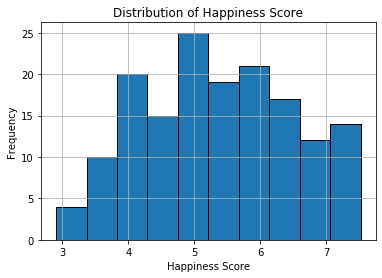

In [9]:
hist = df['Happiness Score'].hist(edgecolor = 'black')
plt.xlabel('Happiness Score')
plt.ylabel('Frequency')
plt.title('Distribution of Happiness Score')

Visually, this distribution appears relatively normal. I learned from this website(https://pythontic.com/pandas/dataframe-computations/skew) that panda has a built-in function that can quantitatively calculate the skewness of distributions. However, it can only be applied to the whole dataframe. So I did the stuffs below.

In [10]:
y_dist = pd.DataFrame({'Score':df['Happiness Score']})
skewValue = y_dist.skew(axis=0)
print(skewValue)

Score    0.043682
dtype: float64


Since the skewness of 0.04 is between -0.5 and 0.5. We can conclude that the distrbution of my dependent variable is relatively symmetric. Therefore, no particular transformation is needed. 

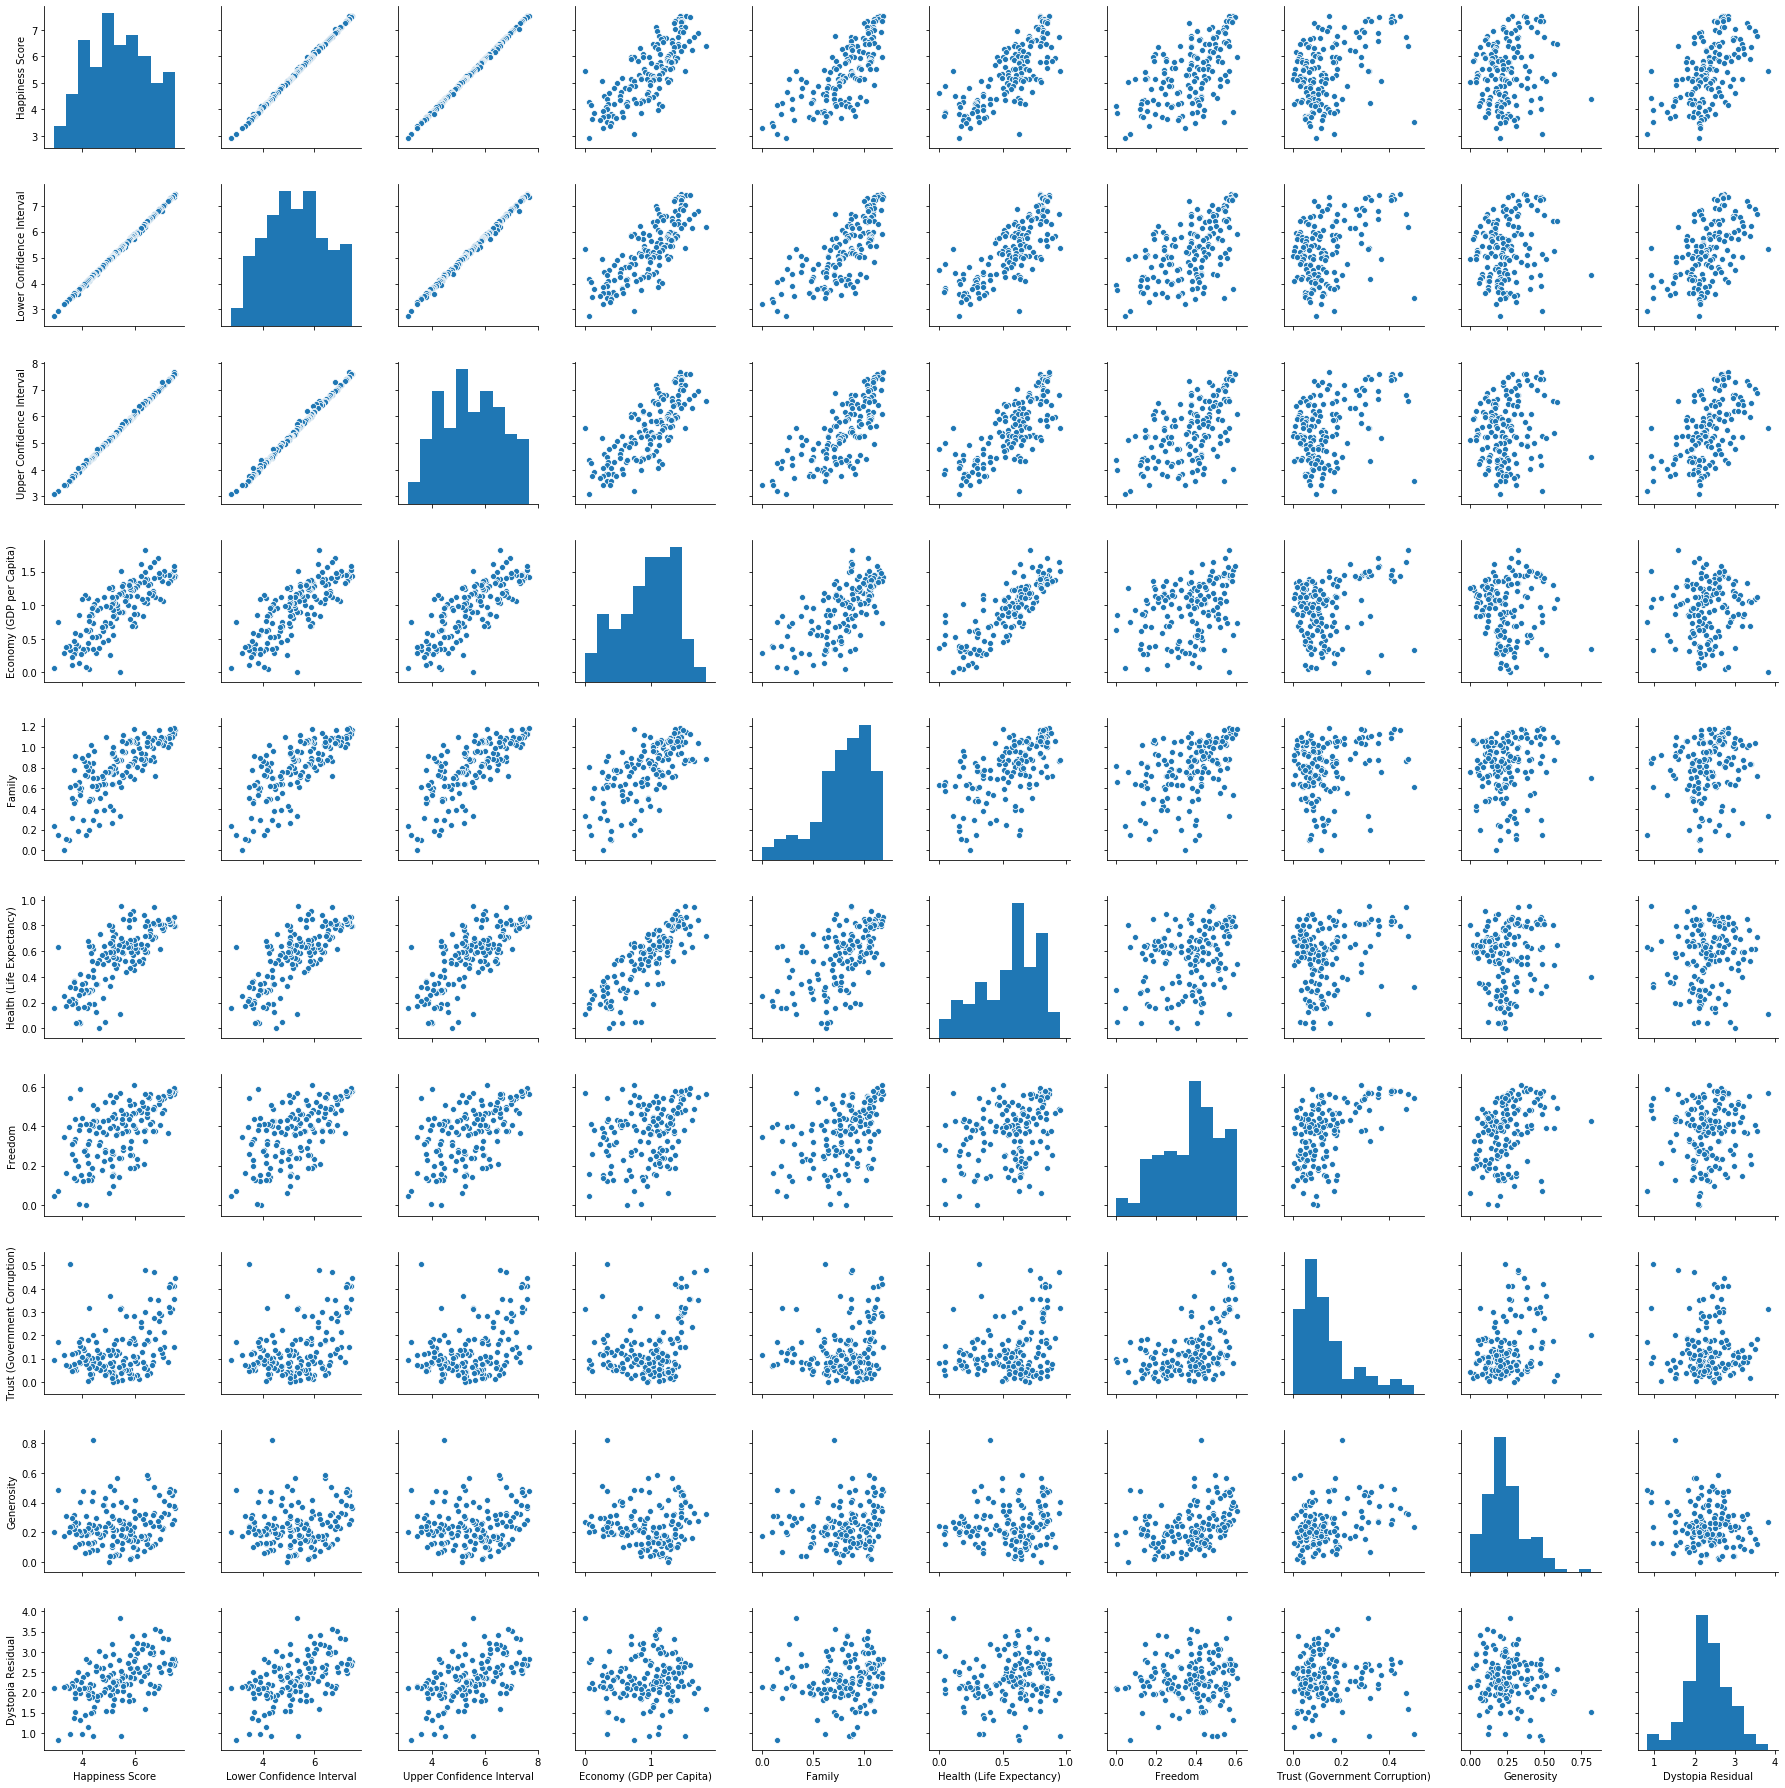

In [11]:
m = df.drop(columns = ['Country','Australia and New Zealand',
       'Central and Eastern Europe', 'Eastern Asia',
       'Latin America and Caribbean', 'Middle East and Northern Africa',
       'North America', 'Southeastern Asia', 'Southern Asia',
       'Sub-Saharan Africa', 'Western Europe'])
sns.pairplot(m)

The first row of pairplots shows the bivariate association between the predictor variables and other variables. I choose "Freedom" as an explanatory variable that does not appear to be linearly related to my predictor variable. Also notably, the "Happiness Score", "Lower Confidence Interval" and "Upper Confidence Interval" are extremely linearly correlated to each other. This makes sense because these three variables are essentially different aspects of the same thing -- the Happiness score. Thus, "Lower Confidence Interval" and "Upper Confidence Interval" will not be proper to be used as explanatory variables to predict the dependent variable. (The logic of avoiding multicollinearity is also compatible with this thinking).

Now let's focus on trying to fit "Happiness Score" vs. "Freedom" with a polynomial of proper degree.

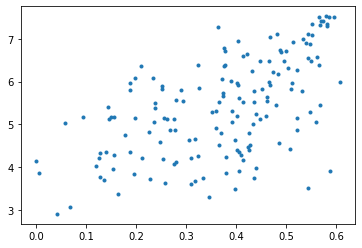

In [12]:
ldf = pd.DataFrame(data={'X':df['Freedom'], 'y':df['Happiness Score']})
plt.plot(ldf['X'], ldf['y'], '.')

In [25]:
ldf = ldf.sample(frac=1).reset_index(drop=True)

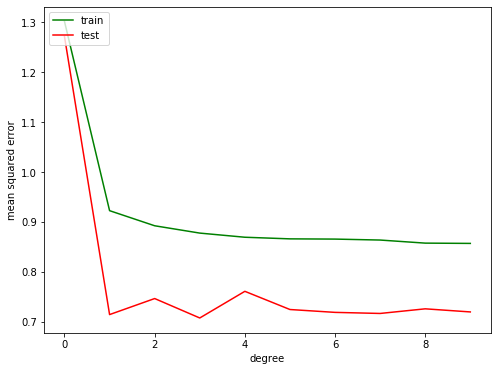

In [27]:


y = ldf['y']
X = ldf.drop(columns = ['y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

degrees = 10

train_error = []
test_error = []

for degree in range(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    train_error.append(mean_squared_error(y_train, model.predict(X_train)))
    test_error.append(mean_squared_error(y_test, model.predict(X_test)))
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(degrees), train_error, color='green', label='train')
plt.plot(np.arange(degrees), test_error, color='red', label='test')
#plt.ylim((0.0, 1e0))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

From the graph above, the 3rd-degree polynomial appears to be an optimal fit.

In [14]:
Cube_Freedom = []
for value in df['Freedom']:
    Cube_Freedom.append(value**3)
df['Cube_Freedom']= Cube_Freedom
df.head()

,Country,Happiness Score,Lower Confidence Interval,Upper Confidence Interval,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,...,Central and Eastern Europe,Eastern Asia,Latin America and Caribbean,Middle East and Northern Africa,North America,Southeastern Asia,Southern Asia,Sub-Saharan Africa,Western Europe,Cube_Freedom
0,Denmark,7.526,7.460,7.592,1.44178,1.16374,0.79504,0.57941,0.44453,0.36171,...,0,0,0,0,0,0,0,0,1,0.194517
1,Switzerland,7.509,7.428,7.590,1.52733,1.14524,0.86303,0.58557,0.41203,0.28083,...,0,0,0,0,0,0,0,0,1,0.200787
2,Iceland,7.501,7.333,7.669,1.42666,1.18326,0.86733,0.56624,0.14975,0.47678,...,0,0,0,0,0,0,0,0,1,0.181552
3,Norway,7.498,7.421,7.575,1.57744,1.12690,0.79579,0.59609,0.35776,0.37895,...,0,0,0,0,0,0,0,0,1,0.211805
4,Finland,7.413,7.351,7.475,1.40598,1.13464,0.81091,0.57104,0.41004,0.25492,...,0,0,0,0,0,0,0,0,1,0.186209


Use a pipeline top scale my data and apply RidgeCV to it.

In [15]:
df = df.sample(frac=1).reset_index(drop=True) #shuffle

X = df.drop(columns = ['Country','Freedom', 'Lower Confidence Interval', 'Upper Confidence Interval','Happiness Score'])
y = df['Happiness Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #This basically splits the dataset into train&validation and test sets.

model = make_pipeline(StandardScaler(), RidgeCV(store_cv_values = True))
model.fit(X_train,y_train)
model

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None,
                         fit_intercept=True, gcv_mode=None, normalize=False,
                         scoring=None, store_cv_values=True))],
         verbose=False)

In [16]:
model.steps[1][1].alpha_

0.1

The RidgeCV model gives that 0.1 is the best alpha value. To see why it is the best, we can show the MSE value corresponding to each alpha.

In [17]:
print(f'MSE for each of the alphas {[0.1,1.,10,]}: {np.mean(model.steps[1][1].cv_values_, axis=0)}')
print(f'MSE corresponding to best alpha {model.steps[1][1].alpha_}: {np.mean(model.steps[1][1].cv_values_, axis=0)[0]}')



MSE for each of the alphas [0.1, 1.0, 10]: [0.00331489 0.00340617 0.01071497]
MSE corresponding to best alpha 0.1: 0.0033148910163628685


Unsurprisingly, the best alpha value, 0.1 has the lowest mean square error.

In [18]:
print(model.steps[1][1].intercept_)
print(model.steps[1][1].coef_)
X.columns

5.418587155963301
[ 4.22577275e-01  2.70615567e-01  2.50097327e-01  1.04165062e-01
  1.39599187e-01  5.17837140e-01 -1.07535012e-02 -3.05973216e-03
  3.71629043e-03  3.28779955e-03  1.96565582e-04 -3.52292645e-04
  2.06208050e-03  3.94946710e-03  1.35796271e-02 -1.81357371e-02
  1.39394936e-01]


Index(['Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Trust (Government Corruption)', 'Generosity', 'Dystopia Residual',
       'Australia and New Zealand', 'Central and Eastern Europe',
       'Eastern Asia', 'Latin America and Caribbean',
       'Middle East and Northern Africa', 'North America', 'Southeastern Asia',
       'Southern Asia', 'Sub-Saharan Africa', 'Western Europe',
       'Cube_Freedom'],
      dtype='object')

#### My model's equation is:

'Happiness Score' = 5.4 + 0.42 * 'Economy (GDP per Capita)' + 0.27 * 'Family' + 0.25 * 'Health (Life Expectancy)' +... 

In [19]:
print(f"R^2 of Train: {model.score(X_train,y_train)}")
print(f"Adjusted R^2 of Train: {1 - (1-model.score(X_train,y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)}")
print(f"MSE of Train: {np.mean(model.fit(X_train,y_train).steps[1][1].cv_values_,axis = 0)[0]}")

print(f"R^2 of Test: {model.score(X_test,y_test)}")
print(f"Adjusted R^2 of Test: {1 - (1-model.score(X_test,y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)}")
print(f"MSE of Test: {np.mean(model.fit(X_test,y_test).steps[1][1].cv_values_,axis = 0)[0]}")




R^2 of Train: 0.9982794801387067
Adjusted R^2 of Train: 0.9979580643404431
MSE of Train: 0.0033148910163628685
R^2 of Test: 0.997407193576787
Adjusted R^2 of Test: 0.995937936603633
MSE of Test: 0.004685503220930003


The R^2, adjusted R^2 and MSE on my train and testing data are pretty close. I'm not overfitting. And they look pretty good!

Bias: The average difference bewteen the average happiness score of our model predicted and the correct happiness score which we are trying to predict.
Vairance: The variability of our model predicting the happiness score. We have a very low variance, which means that our model not only performs well on the training set but also well on the test set. There's no overemphasis on the training set.